In [4]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [347]:
def ddx(f, dx):
    return (np.roll(f, -1, axis=-2) - np.roll(f, 1, axis=-2)) / (2 * dx)


def ddy(f, dy):
    return (np.roll(f, -1, axis=-1) - np.roll(f, 1, axis=-1)) / (2 * dy)


def shallow_water(state, dx):
    h, u, v = np.split(state, 3, axis=-1)
    h = h.squeeze()
    u = u.squeeze()
    v = v.squeeze()
    
    g = 9.81
    f = 1e-4
    k = 1e-4 + np.random.rand() * 1e-5
    # compute derivatives
    dhdt = - 1 * (ddx(u, dx) + ddy(v, dx))
    dudt = - g * ddx(h, dx) + f*v - k*u
    dvdt = - g * ddy(h, dx) - f*u - k*v
    return np.stack([dhdt, dudt, dvdt], axis=-1).astype(np.float32)

def RK_integration(state, dt, dx):
    k1 = shallow_water(state, dx)
    k2 = shallow_water(state + 0.5*dt*k1, dx)
    k3 = shallow_water(state + 0.5*dt*k2, dx)
    k4 = shallow_water(state + dt*k3, dx)
    return (state + dt/6 * (k1 + 2*k2 + 2*k3 + k4)).astype(np.float32)

def cycle(model, assimilation, t0, tf, interval):
    t = t0
    while t < tf:
        model.run_until(t+interval)
        assimilation.analysis()
        t += interval




In [344]:
X = 100
Y = 100

class Truth:
    dx = 1.0
    dy = dx
    def __init__(self):
        self.dt = 0.1
        self.nx = int(X // self.dx)
        self.ny = int(Y // self.dy)
        self.x_1d = np.linspace(0, self.nx*self.dx, self.nx)
        self.y_1d = np.linspace(0, self.ny*self.dy, self.ny)
        self.y_2d, self.x_2d = np.meshgrid(self.y_1d, self.x_1d)
        self.u0 = np.random.random(size=(self.nx, self.ny)) * 0.01
        self.v0 = np.random.random(size=(self.nx, self.ny)) * 0.01
        self.h_max = 0.1
        self.h0 = np.sin(2*np.pi*self.x_2d/self.nx) * np.sin(2*np.pi*self.y_2d/self.ny) * self.h_max
        self.state = np.stack([self.h0, self.u0, self.v0], axis=-1).astype(np.float32)
        self.history = self.state.reshape((1, self.nx, self.ny, 3))
        self.time = np.array([0])
        return
    
    def step(self):
        self.state = RK_integration(self.state, self.dt, self.dx).astype(np.float32)
        self.history = np.concat([self.history, self.state.reshape((1, self.nx, self.ny, 3))], axis=0)
        self.time = np.hstack([self.time, self.time[-1] + self.dt])
        return
    
    def run_until(self, t):
        while not self.time[-1] + self.dt/2 > t:
            self.step()
        return
    
    def get_value(self, t, x, y, var):
        idx_x = np.argmin(np.abs(self.x_1d - x))
        idx_y = np.argmin(np.abs(self.y_1d - y))
        idx_t = np.argmin(np.abs(self.time - t))
        idx_var = ['h', 'u', 'v'].index(var)
        return self.history[idx_t, idx_x, idx_y, idx_var]
    
    def get_timeline(self, x, y, var):
        idx_x = np.argmin(np.abs(self.x_1d - x))
        idx_y = np.argmin(np.abs(self.y_1d - y))
        idx_var = ['h', 'u', 'v'].index(var)
        return self.history[:, idx_x, idx_y, idx_var]
    
    def plot_timeline(self, x, y, var, **kwargs):
        idx_x = int(np.round(x / self.dx))
        idx_y = int(np.round(y / self.dy))
        idx_var = ['h', 'u', 'v'].index(var)
        args_dict = {'linewidth': 2, "color": 'tab:green'}
        args_dict.update(kwargs)
        plt.plot(self.time, self.history[:, idx_x, idx_y, idx_var], **args_dict)

    def plot_state(self, t=None):
        if t is None:
            t = self.time[-1]
        idx_t = np.argmin(np.abs(self.time - t))
        cax = plt.pcolormesh(self.x_2d, self.y_2d,
                             self.history[idx_t, :, :, 0],
                             vmin=-self.h_max, vmax=self.h_max)
        sample = self.nx // 10
        plt.quiver(self.x_2d[::sample,::sample],
                   self.y_2d[::sample,::sample],
                   self.history[idx_t, ::sample, ::sample, 1],
                   self.history[idx_t, ::sample, ::sample, 2])
        plt.colorbar(cax)
        plt.show()



class Model(Truth):
    def __init__(self, ens_size=10, dx=5):
        self.ens_size = ens_size
        self.dt = 1
        self.dx = dx
        self.dy = dx
        self.nx = int(X // self.dx)
        self.ny = int(Y // self.dy)
        self.x_1d = np.arange(0, self.nx*self.dx, self.dx)
        self.y_1d = np.arange(0, self.ny*self.dy, self.dy)
        self.y_2d, self.x_2d = np.meshgrid(self.y_1d, self.x_1d)
        self.u0 = np.zeros((self.ens_size, self.nx, self.ny))
        self.v0 = np.zeros((self.ens_size, self.nx, self.ny))
        self.h_max = 0.1
        self.h0 = np.ones((self.ens_size, self.nx, self.ny)) * self.h_max
        self.state = np.stack([self.h0, self.u0, self.v0], axis=-1)
        self.history = self.state.reshape((1, self.ens_size, self.nx, self.ny, 3))
        self.time = np.array([0])
        return
    
    def initiate(self, truth, time=None, epsilon=0.01):
        if time is None:
            time = 0
        self.state = np.zeros((self.ens_size, self.nx, self.ny, 3))
        for i in range(self.nx):
            for j in range(self.ny):
                self.state[:, i, j, 0] = np.full(self.ens_size, truth.get_value(time, i * self.dx, j * self.dy, 'h'))
                self.state[:, i, j, 1] = np.full(self.ens_size, truth.get_value(time, i * self.dx, j * self.dy, 'u'))
                self.state[:, i, j, 2] = np.full(self.ens_size, truth.get_value(time, i * self.dx, j * self.dy, 'v'))
        self.state += epsilon * (np.random.random(size=(self.ens_size, self.nx, self.ny, 3)) - 0.5) * 2
        self.history = self.state.reshape((1, self.ens_size, self.nx, self.ny, 3))
        self.time = np.array([time]) #np.array([0])
        return
    
    def blank_start(self):
        self.state = np.random.random((self.ens_size, self.nx, self.ny, 3)) * self.h_max
        self.history = self.state.reshape((1, self.ens_size, self.nx, self.ny, 3))
        self.time = np.array([0])
        return
    
    def step(self):
        #for i in range(self.ens_size):
        #    self.state[i] = RK_integration(self.state[i], self.dt, self.dx)
        self.state = RK_integration(self.state, self.dt, self.dx)
        self.history = np.concatenate([self.history, self.state.reshape((1, self.ens_size, self.nx, self.ny, 3))], axis=0)
        self.time = np.hstack([self.time, self.time[-1] + self.dt])
        return
    
    def get_B(self):
        error = self.state - np.mean(self.state, axis=0)
        error = error.reshape((self.ens_size, self.nx * self.ny * 3))
        B = error.T @ error / (self.ens_size - 1)
        return B
    
    def get_H(self, obs):
        H = np.zeros((obs.n_obs, self.nx * self.ny * 3))
        for i in range(obs.n_obs):
            x, y = obs.coordinates[i]
            idx_x = np.argmin(np.abs(self.x_1d - x))
            idx_y = np.argmin(np.abs(self.y_1d - y))
            idx_var = ['h', 'u', 'v'].index(obs.var[i])
            H[i, np.ravel_multi_index((idx_x, idx_y, idx_var), (self.nx, self.ny, 3))] = 1
        return H
    
    def get_value(self, t, x, y, var):
        idx_x = int(np.round(x / self.dx))
        idx_y = int(np.round(y / self.dy))
        idx_t = int(np.round(t / self.dt))
        idx_var = ['h', 'u', 'v'].index(var)
        return self.history[idx_t, :, idx_x, idx_y, idx_var]
    
    def get_mean_value(self, t, x, y, var):
        idx_x = int(np.round(x / self.dx))
        idx_y = int(np.round(y / self.dy))
        idx_t = int(np.round(t / self.dt))
        idx_var = ['h', 'u', 'v'].index(var)
        return np.mean(self.history[idx_t, :, idx_x, idx_y, idx_var])
    
    def get_mean_timeline(self, x, y, var):
        idx_x = int(np.round(x / self.dx))
        idx_y = int(np.round(y / self.dy))
        idx_var = ['h', 'u', 'v'].index(var)
        return np.mean(self.history[:, :, idx_x, idx_y, idx_var], axis=1)
    
    def plot_mean_timeline(self, x, y, var, **kwargs):
        idx_x = int(np.round(x / self.dx))
        idx_y = int(np.round(y / self.dy))
        idx_var = ['h', 'u', 'v'].index(var)
        args_dict = {'linewidth': 2, "color": 'tab:red'}
        args_dict.update(kwargs)
        plt.plot(self.time, np.mean(self.history[:, :, idx_x, idx_y, idx_var], axis=1), **args_dict)

    def plot_spaghetti_timeline(self, x, y, var, **kwargs):
        idx_x = int(np.round(x / self.dx))
        idx_y = int(np.round(y / self.dy))
        idx_var = ['h', 'u', 'v'].index(var)
        args_dict = {'linewidth': 0.1, "color": 'k'}
        args_dict.update(kwargs)
        for i in range(self.ens_size):
            plt.plot(self.time, self.history[:, i, idx_x, idx_y, idx_var], **args_dict)


    def plot_state(self, t=None):
        if t is None:
            t = self.time[-1]
        idx_t = np.argmin(np.abs(self.time - t))
        cax = plt.pcolormesh(self.x_2d, self.y_2d,
                             self.history[idx_t,:,:,:,0].mean(axis=0),
                             vmin=-self.h_max, vmax=self.h_max)
        sample = self.nx // 10
        plt.quiver(self.x_2d[::sample,::sample], self.y_2d[::sample,::sample],
                   self.history[idx_t, :, ::sample, ::sample, 1].mean(axis=0),
                   self.history[idx_t, :, ::sample, ::sample, 2].mean(axis=0))
        plt.colorbar(cax)
        plt.show()

    def evaluate(self, truth):
        truth_history = np.empty((len(self.time), self.nx, self.ny, 3))
        for t in range(len(self.time)):
            for i in range(self.nx):
                for j in range(self.ny):
                    for k in range(3):
                        truth_history[t, i, j, k] = truth.get_value(self.time[t], i * self.dx, j * self.dy, ['h', 'u', 'v'][k])
        error = np.sqrt(np.mean((np.mean(self.history, axis=1) - truth_history)**2, axis=(1, 2)))
        error_h, error_u, error_v = np.split(error, 3, axis=-1)
        error_h = error_h.squeeze()
        error_u = error_u.squeeze()
        error_v = error_v.squeeze()
        return error_h, error_u, error_v
    
    def plot_error(self, truth):
        error_h, error_u, error_v = self.evaluate(truth)
        plt.plot(self.time, error_h, label='h')
        plt.plot(self.time, error_u, label='u')
        plt.plot(self.time, error_v, label='v')
        plt.legend()

    def plot_spread(self):
        spread = np.std(self.history, axis=1)
        spread = np.mean(spread, axis=(1,2))
        spread_h, spread_u, spread_v = np.split(spread, 3, axis=-1)
        spread_h = spread_h.squeeze()
        spread_u = spread_u.squeeze()
        spread_v = spread_v.squeeze()
        plt.plot(self.time, spread_h, label='h')
        plt.plot(self.time, spread_u, label='u')
        plt.plot(self.time, spread_v, label='v')
        plt.legend()
    


class Observation:
    def __init__(self, truth, coordinates, var, noise=0.01):
        self.truth = truth
        self.noise = noise
        self.coordinates = coordinates # np.array of coordinates
        self.var = var # list of variables
        self.n_obs = len(coordinates)
        return
    
    def get_value(self, t):
        obs = []
        index_t = int(np.round(t / self.truth.dt))
        for i in range(self.n_obs):
            x, y = self.coordinates[i]
            obs.append((self.truth.get_value(t, x, y, self.var[i]) + np.random.normal(0, self.noise)).astype(np.float32))
        return np.array(obs), self.coordinates, self.var
    
    def get_R(self):
        return np.eye(self.n_obs) * self.noise**2 * 100
    

class EnKF:
    def __init__(self, model, obs):
        self.model = model
        self.obs = obs
        self.R = obs.get_R()
        self.H = model.get_H(obs)
        self.n_obs = self.obs.n_obs
        self.nx = self.model.nx
        self.ny = self.model.ny
        self.ens_size = self.model.ens_size

    def compute_departure(self):
        time = self.model.time[-1]
        obs, coordinates, var = self.obs.get_value(time)
        obs_noise = np.random.normal(0, self.obs.noise, size=(self.ens_size, self.n_obs))
        H = self.H
        Hx = H @ self.model.state.reshape((self.ens_size, self.nx * self.ny * 3)).T
        self.departure = obs + obs_noise - Hx.T
        return self.departure

    def compute_kalman_gain(self):
        B = self.model.get_B()
        H = self.H
        R = self.R
        K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
        self.K = K
        return self.K
    
    def analysis(self):
        self.compute_kalman_gain()
        self.compute_departure()
        analysis = self.model.state + np.reshape((self.K @ self.departure.T).T, (self.ens_size, self.nx, self.ny, 3))
        self.model.state = analysis
        self.model.history = np.concatenate([self.model.history, analysis.reshape((1, self.ens_size, self.nx, self.ny, 3))], axis=0)
        self.model.time = np.hstack([self.model.time, self.model.time[-1]])
        



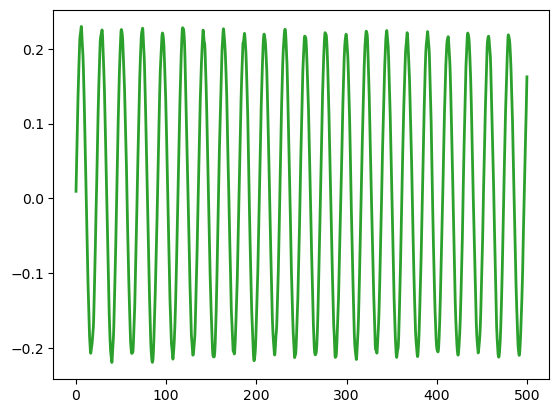

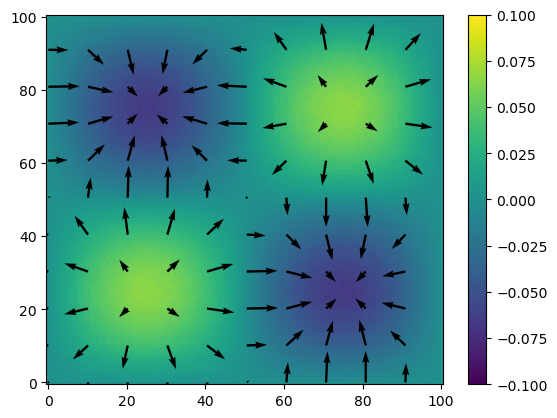

In [ ]:
truth = Truth()
truth.run_until(500)
truth.plot_timeline(25, 50, 'v')
plt.show()
truth.plot_state()

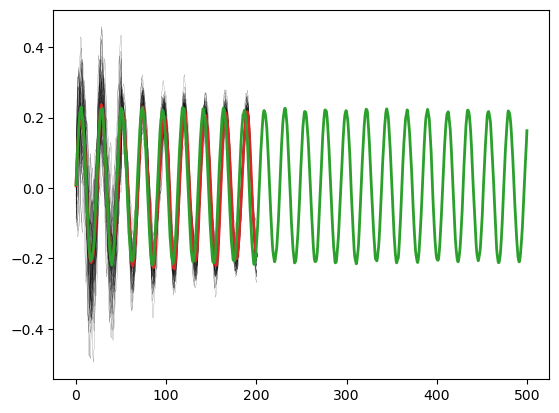

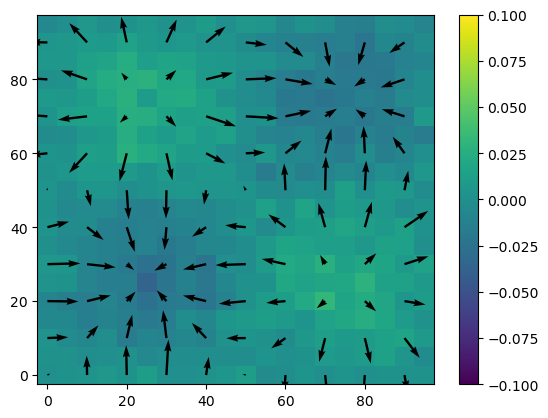

In [372]:
model = Model(ens_size=50)
obs = Observation(truth, np.stack([model.x_2d.flatten(), model.y_2d.flatten()], axis=1),
                  model.nx * model.ny * ['h'], noise=0.01)
assimilation = EnKF(model, obs)
model.blank_start()
model.initiate(truth, time=0, epsilon=0.1)

cycle(model, assimilation, 0, 200, 50)

model.plot_spaghetti_timeline(25, 50, 'v')
model.plot_mean_timeline(25, 50, 'v')
truth.plot_timeline(25, 50, 'v')
plt.show()

model.plot_state()

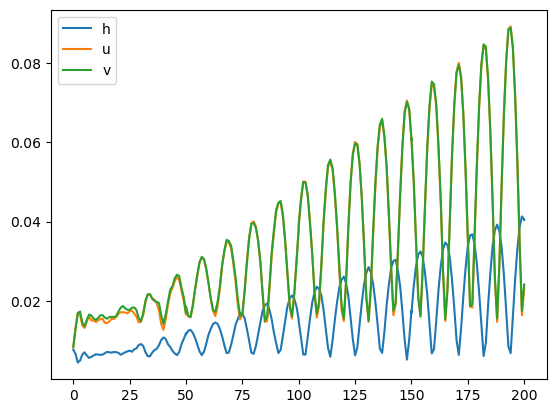

In [373]:
model.plot_error(truth)
plt.show()

[]

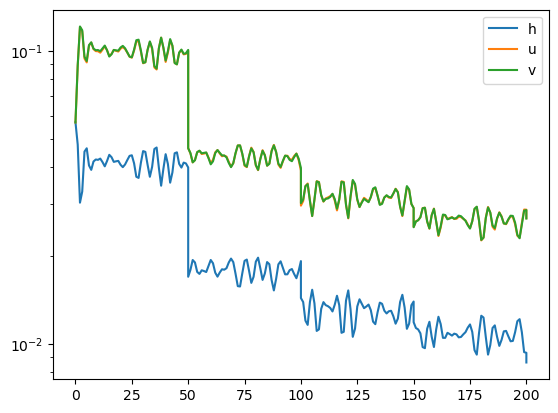

In [374]:
model.plot_spread()
plt.semilogy()

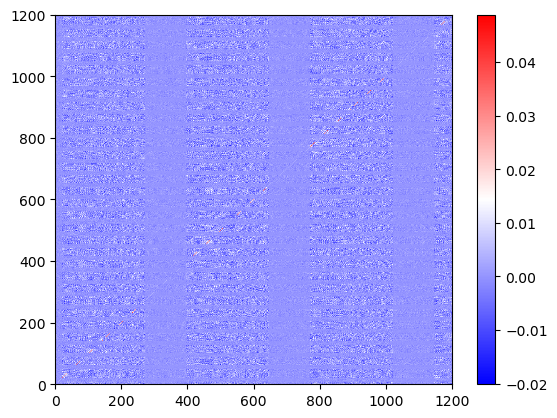

In [367]:
B = model.get_B()
plt.pcolormesh(B, cmap='bwr')
plt.colorbar()

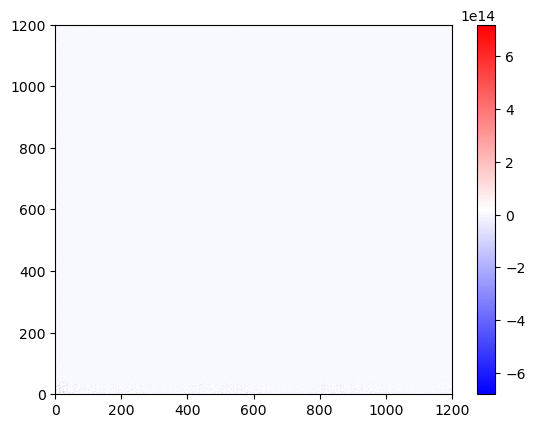

In [368]:
plt.pcolormesh(np.linalg.pinv(B), cmap='bwr')
plt.colorbar()